## Sagnac Frequency - Compare Drift of Rings

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
from functions.interpolate_nan import __interpolate_nan

In [4]:
def __get_mlti_intervals(mlti_times):

    from obspy import UTCDateTime
    from numpy import array

    t1, t2 = [], []
    for k,_t in enumerate(mlti_times):

        _t = UTCDateTime(_t)

        if k == 0:
            _tlast = _t
            t1.append(_t)

        if _t -_tlast > 60:
            t2.append(_tlast)
            t1.append(_t)

        _tlast = _t

    t2.append(_t)

    return array(t1), array(t2)

In [5]:
def __load_beat(tbeg, tend, ring, path_to_data):

    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range
    from obspy import UTCDateTime


    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    dd1 = date.fromisoformat(str(tbeg.date))
    dd2 = date.fromisoformat(str(tend.date))

    df = DataFrame()
    for dat in date_range(dd1, dd2):
        file = f"{str(dat)[:4]}/R{ring}/FJ{ring}_"+str(dat)[:10].replace("-", "")+".pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")
    if df.empty:
        print(" -> empty dataframe!")
        return df

    ## trim to defined times
    df = df[(df.times_utc >= tbeg) & (df.times_utc < tend)]

    ## correct seconds
    df['times_utc_sec'] = [abs(tbeg - UTCDateTime(_t))  for _t in df['times_utc']]

    return df

In [6]:
def __smooth(y, npts):

    from numpy import ones, convolve, hanning, nan

    win = hanning(npts)
    y_smooth = convolve(y, win/sum(win), mode='same')

    y_smooth[:npts//2] = nan
    y_smooth[-npts//2:] = nan
    return y_smooth

In [7]:
def __get_mlti_intervals(mlti_times):

    from obspy import UTCDateTime
    from numpy import array

    t1, t2 = [], []
    for k,_t in enumerate(mlti_times):

        _t = UTCDateTime(_t)

        if k == 0:
            _tlast = _t
            t1.append(_t)

        if _t -_tlast > 60:
            t2.append(_tlast)
            t1.append(_t)

        _tlast = _t

    t2.append(_t)

    return array(t1), array(t2)

In [8]:
def __get_mlti_intervals(mlti_times):

    from obspy import UTCDateTime
    from numpy import array

    t1, t2 = [], []
    for k,_t in enumerate(mlti_times):

        _t = UTCDateTime(_t)

        if k == 0:
            _tlast = _t
            t1.append(_t)

        if _t -_tlast > 60:
            t2.append(_tlast)
            t1.append(_t)

        _tlast = _t

    t2.append(_t)

    return array(t1), array(t2)

In [9]:
def __load_mlti(tbeg, tend, ring, path_to_archive):

    from obspy import UTCDateTime
    from pandas import read_csv, concat

    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    rings = {"U":"03", "Z":"01", "V":"02", "W":"04"}

    if tbeg.year == tend.year:
        year = tbeg.year

        path_to_mlti = path_to_archive+f"romy_archive/{year}/BW/CROMY/{year}_romy_{rings[ring]}_mlti.log"

        mlti = read_csv(path_to_mlti, names=["time_utc","Action","ERROR"])

    else:

        path_to_mlti1 = path_to_archive+f"romy_archive/{tbeg.year}/BW/CROMY/{tbeg.year}_romy_{rings[ring]}_mlti.log"
        mlti1 = read_csv(path_to_mlti1, names=["time_utc","Action","ERROR"])

        path_to_mlti2 = path_to_archive+f"romy_archive/{tend.year}/BW/CROMY/{tend.year}_romy_{rings[ring]}_mlti.log"
        mlti2 = read_csv(path_to_mlti2, names=["time_utc","Action","ERROR"])

        mlti = concat([mlti1, mlti2])

    mlti = mlti[(mlti.time_utc > tbeg) & (mlti.time_utc < tend)]

    return mlti

In [10]:
def __mlti_intervals_to_NaN(df_in, mlti_t1, mlti_t2, t_offset_sec=120):

    from numpy import nan, where

    df_in['fj_nan'] = df_in['fj']

    for t1, t2 in zip(mlti_t1, mlti_t2):

        ## trim times to minutes and add t_offset_sec
        tt1, tt2 = str(t1-t_offset_sec)[:16], str(t2+t_offset_sec)[:16]

        ## replace data during mlti times with NaN values
        df_in['fj_nan'] = where((df_in.times_utc > str(tt1)) & (df_in.times_utc < str(tt2)), nan, df_in['fj_nan'])

    return df_in

## Configurations

In [11]:
config = {}

config['tbeg'] = UTCDateTime("2023-12-01 00:00")
config['tend'] = UTCDateTime("2023-12-15 00:00")

config['path_to_sds'] = archive_path+"romy_archive/"

## path to Sagnac Beat data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [12]:
beatU = __load_beat(config['tbeg'], config['tend'], "U", config['path_to_autodata'])
beatZ = __load_beat(config['tbeg'], config['tend'], "Z", config['path_to_autodata'])
beatV = __load_beat(config['tbeg'], config['tend'], "V", config['path_to_autodata'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


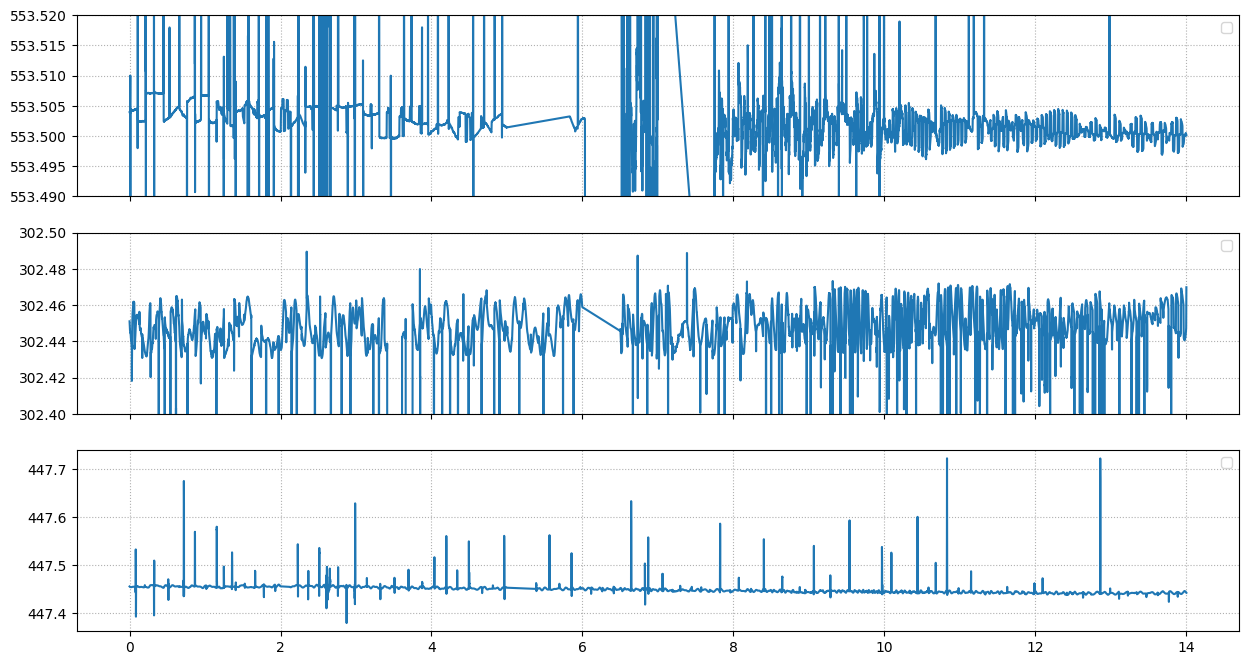

In [13]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    time_scaling = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj)
    ax[0].set_ylim(553.49, 553.52)
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj)
    ax[1].set_ylim(302.4, 302.5)
    ax[1].ticklabel_format(useOffset=False)

    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj)
    # ax[2].set_ylim(447.4, 447.6)
    ax[2].ticklabel_format(useOffset=False)

    # ax[2].axhline(np.nanpercentile(beatV.fj, 99))
    # ax[2].axhline(np.nanpercentile(beatV.fj, 1))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    plt.show();
    return fig

fig = __makeplot();


## Remove breakdown periods

In [14]:
times = [("2023-12-04T09:10", "2023-12-04T18:02"),
         ("2023-12-20T06:10", "2023-12-20T12:01")]

for t1, t2 in times:
    beatU['fj'] = np.where((beatU.times_utc > t1) & (beatU.times_utc < t2), np.nan, beatU['fj'])

# beatU['fj'] = np.nan_to_num(beatU['fj'], nan=np.nanmedian(beatU['fj']))

In [15]:
times = [("2024-01-01T04:00", "2024-01-01T22:51"),
         ("2024-01-03T14:20", "2024-01-06T00:00"),
         ("2023-12-19T09:40", "2023-12-19T15:21")]

for t1, t2 in times:
    beatV['fj'] = np.where((beatV.times_utc > t1) & (beatV.times_utc < t2), np.nan, beatV['fj'])

# beatV['fj'] = np.nan_to_num(beatV['fj'], nan=np.nanmedian(beatV['fj']))

In [16]:
times = [("2023-12-07T00:10", "2023-12-08T18:05")]

for t1, t2 in times:
    beatZ['fj'] = np.where((beatZ.times_utc > t1) & (beatZ.times_utc < t2), np.nan, beatZ['fj'])

# beatZ['fj'] = np.nan_to_num(beatZ['fj'], nan=np.nanmedian(beatZ['fj']))

In [17]:
# beatU['fj'] = np.where((beatU.times_utc < "2023-12-20T07:00:30") & (beatU.fj < 302.4), np.nan, beatU.fj)
beatU['fj'] = np.where((beatU.fj < 302.4), np.nan, beatU.fj)

## cut off outliers manually
beatU['fj'] = np.where((beatU.times_utc > "2023-12-18T20:40") & (beatU.times_utc < "2023-12-19T05:00") & (beatU.fj < 302.48), np.nan, beatU.fj)


In [18]:
beatZ['fj'] = np.where((beatZ.fj > 553.515), np.nan, beatZ.fj)

In [20]:
# i1, i2 = 25000, 25500

# # print(beatZ.times_utc.iloc[i1], beatZ.times_utc.iloc[i2])
# # plt.plot(beatZ.times_utc_sec.iloc[i1:i2], beatZ.fj.iloc[i1:i2])

# print(beatU.times_utc.iloc[i1], beatU.times_utc.iloc[i2])
# plt.plot(beatU.times_utc_sec.iloc[i1:i2], beatU.fj.iloc[i1:i2])
# # plt.plot(beatU.times_utc_sec.iloc[i1:i2], beatU.fj_nan.iloc[i1:i2])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


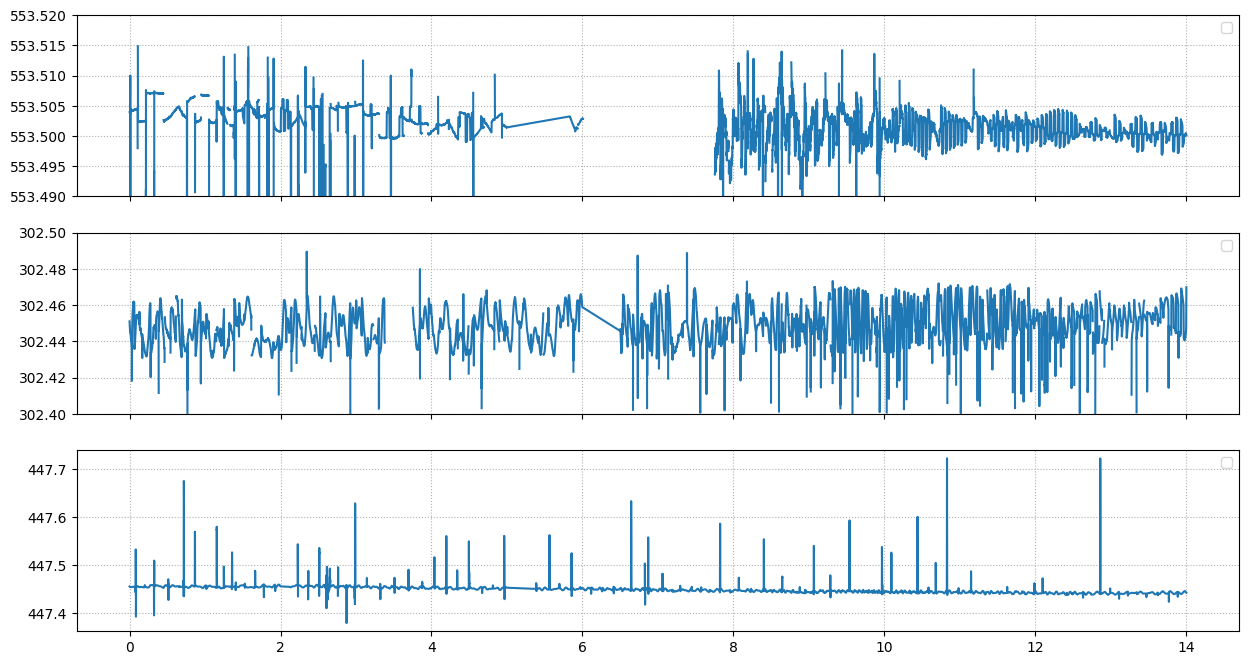

In [21]:
fig = __makeplot();

## Remove MLTI times

In [22]:
mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

In [23]:
mltiZ = __load_mlti(config['tbeg'], config['tend'], "Z", archive_path)

In [24]:
mltiV = __load_mlti(config['tbeg'], config['tend'], "V", archive_path)

In [25]:
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [26]:
mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

In [27]:
mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)

In [28]:
# # df, mlti, mlti_t1, mlti_t2  = beatU, mltiU, mltiU_t1, mltiU_t2
# # df, mlti, mlti_t1, mlti_t2  = beatV, mltiV, mltiV_t1, mltiV_t2
# df, mlti, mlti_t1, mlti_t2  = beatZ, mltiZ, mltiZ_t1, mltiZ_t2


# time_axis = df.times_utc_sec-df.times_utc_sec.iloc[0]
# plt.plot(time_axis, df.fj, zorder=2)

# # for m in mlti.time_utc:
# #     plt.axvline((UTCDateTime(m)-config['tbeg'])/86400, color="red", zorder=0, alpha=0.5)

# miny, maxy = min(df.fj), max(df.fj)
# for t1, t2 in zip(mlti_t1, mlti_t2):
#     plt.fill_betweenx([miny, maxy], t1-config['tbeg'], t2-config['tbeg'], color="red", alpha=0.5;

In [29]:
# i1, i2 = 20400, 26819

# print(beatV.times_utc.iloc[i1], beatV.times_utc.iloc[i2])
# plt.plot(beatV.times_utc_sec.iloc[i1:i2], beatV.fj.iloc[i1:i2])

In [30]:
beatU = __mlti_intervals_to_NaN(beatU, mltiU_t1, mltiU_t2, t_offset_sec=180)
beatV = __mlti_intervals_to_NaN(beatV, mltiV_t1, mltiV_t2, t_offset_sec=180)
beatZ = __mlti_intervals_to_NaN(beatZ, mltiZ_t1, mltiZ_t2, t_offset_sec=180)

## Interpolate NaN values

In [31]:
beatU['fj_inter'] = __interpolate_nan(np.array(beatU.fj_nan))
beatV['fj_inter'] = __interpolate_nan(np.array(beatV.fj_nan))
beatZ['fj_inter'] = __interpolate_nan(np.array(beatZ.fj_nan))

## Smoothing

In [32]:
n_minutes = 600

beatU['fj_smooth'] = __smooth(beatU.fj_inter, n_minutes)
beatV['fj_smooth'] = __smooth(beatV.fj_inter, n_minutes)
beatZ['fj_smooth'] = __smooth(beatZ.fj_inter, n_minutes)

## Plotting

/tmp/ipykernel_1006134/2298570417.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[Nrow-1].set_xticklabels(tcklbls)


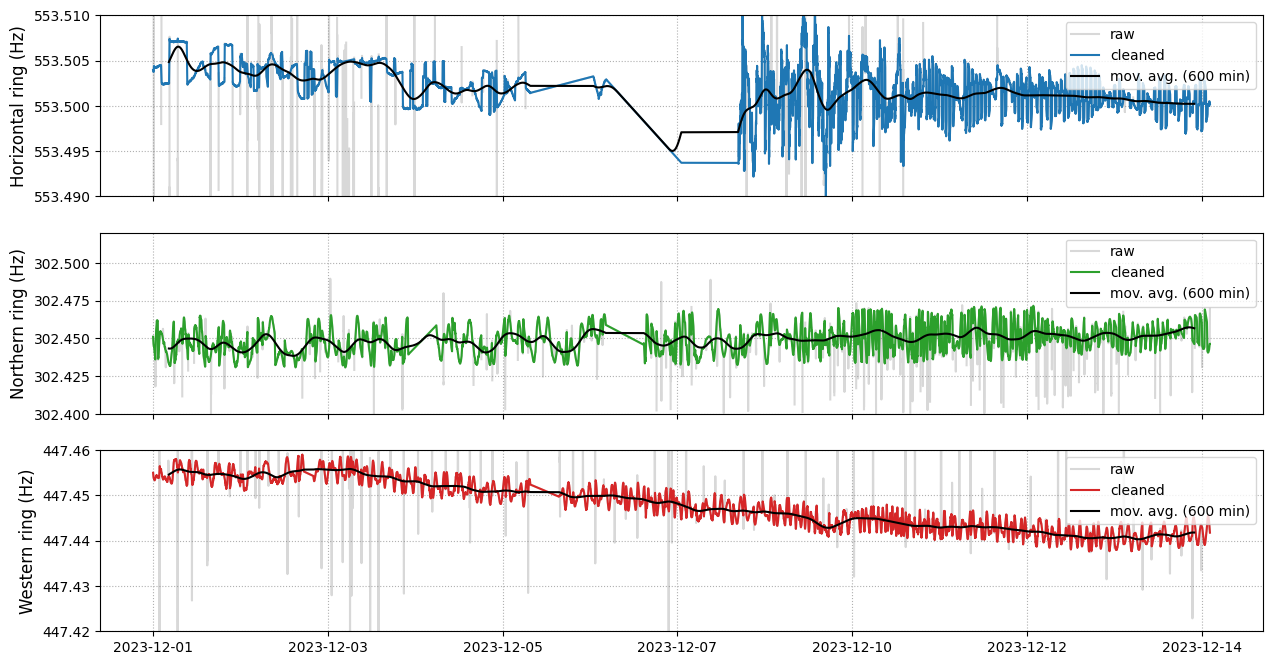

In [33]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_inter, color="tab:blue", label="cleaned")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[0].set_ylim(553.49, 553.51)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("Horizontal ring (Hz)", fontsize=font)

    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_inter, color="tab:green", label="cleaned")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[1].set_ylim(302.4, 302.52)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("Northern ring (Hz)", fontsize=font)

    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_inter, color="tab:red", label="cleaned")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[2].set_ylim(447.42, 447.46)
    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("Western ring (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)
        # ax[_n].set_xlim(left=0)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    ## add dates to x-axis
    ref_date = UTCDateTime(beatZ.times_utc.iloc[0][:10])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BeatDrift_smoothed.png", format="png", dpi=150, bbox_inches='tight')


In [34]:
beatU['fj_reduced'] = beatU['fj_smooth'] - np.abs(np.nanmean(beatU['fj_smooth'].iloc[:500]))
beatV['fj_reduced'] = beatV['fj_smooth'] - np.abs(np.nanmean(beatV['fj_smooth'].iloc[:500]))
beatZ['fj_reduced'] = beatZ['fj_smooth'] - np.abs(np.nanmean(beatZ['fj_smooth'].iloc[:500]))

In [35]:
def __sagnac_to_tilt(data, ring):

    from numpy import pi, sqrt, arccos, deg2rad, arcsin

    dip = {"Z":0, "U":109.5, "V":70.5, "W":70.5}

    L = {"Z":11.2, "U":12, "V":12, "W":12}

    ## Scale factor
    S = (sqrt(3)*L[ring])/(3*632.8e-9)

    ## ROMY latitude
    lat = 48.162941

    ## nominal Earth rotation
    omegaE = 2*pi/86400

    return arcsin(data /omegaE /S) - deg2rad(lat) - deg2rad(dip[ring])

In [36]:
L = {"Z":11.2, "U":12, "V":12, "W":12}

## Scale factor
S = (np.sqrt(3)*12/(3*632.8e-9))

## ROMY latitude
lat = 48.162941

## nominal Earth rotation
omegaE = 2*np.pi/86400

S* omegaE * np.sin(np.deg2rad(lat)) * np.cos(np.deg2rad(19.5))

559.1768362490966

In [37]:
a = 0
b = 19.5
c = 30

from scipy.spatial.transform import Rotation as R

aa, bb, cc = np.deg2rad(a), np.deg2rad(b), np.deg2rad(c)

rx = R.from_matrix([[1,0,0],[0,np.cos(aa),-np.sin(aa)],[0,np.sin(aa),np.cos(aa)]])
ry = R.from_matrix([[np.cos(bb),0,np.sin(bb)],[0,1,0],[-np.sin(bb),0,np.cos(bb)]])
rz = R.from_matrix([[np.cos(cc),-np.sin(cc),0],[np.sin(cc),np.cos(cc),0],[0,0,1]])

v = [0, 0, 1]
vx = rx.apply(v)
vxy = ry.apply(vx)
vxyz = rz.apply(vxy)

vxyz

array([0.28908522, 0.16690343, 0.94264149])

In [38]:
beatZ['tilt'] = __sagnac_to_tilt(beatZ['fj_reduced'], "Z")
beatU['tilt'] = __sagnac_to_tilt(beatU['fj_reduced'], "U")
beatV['tilt'] = __sagnac_to_tilt(beatV['fj_reduced'], "V")

beatU['tilt_reduced'] = beatU.tilt - np.nanmean(beatU.tilt.iloc[:500])
beatV['tilt_reduced'] = beatV.tilt - np.nanmean(beatV.tilt.iloc[:500])
beatZ['tilt_reduced'] = beatZ.tilt - np.nanmean(beatZ.tilt.iloc[:500])

In [39]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    time_scaling = 1/86400
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta f$ (Hz)", fontsize=font)

    ax[1].plot(beatZ.times_utc_sec*time_scaling, beatZ.tilt_reduced*tilt_scaling, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[1].plot(beatV.times_utc_sec*time_scaling, beatV.tilt_reduced*tilt_scaling, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.tilt_reduced*tilt_scaling, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")


    ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.04, 0.07)

    ## add dates to x-axis
    ref_date = UTCDateTime(beatZ.times_utc.iloc[0][:10])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

# fig = __makeplot();


## Rotate to ZNE

In [40]:
tr_beatU = Trace()
tr_beatU.data = np.array(beatU.fj_reduced)
tr_beatU.stats.delta = 60
tr_beatU.stats.starttime = UTCDateTime(str(beatU.times_utc.iloc[0]))
tr_beatU.stats.network, tr_beatU.stats.station, tr_beatU.stats.channel = "BW", "ROMY", "LJU"
# tr_beatU.plot();

tr_beatV = Trace()
tr_beatV.data = np.array(beatV.fj_reduced)
tr_beatV.stats.delta = 60
tr_beatV.stats.starttime = UTCDateTime(str(beatV.times_utc.iloc[0]))
tr_beatV.stats.network, tr_beatV.stats.station, tr_beatV.stats.channel = "BW", "ROMY", "LJV"
# tr_beatV.plot();

tr_beatZ = Trace()
tr_beatZ.data = np.array(beatZ.fj_reduced)
tr_beatZ.stats.delta = 60
tr_beatZ.stats.starttime = UTCDateTime(str(beatZ.times_utc.iloc[0]))
tr_beatZ.stats.network, tr_beatZ.stats.station, tr_beatZ.stats.channel = "BW", "ROMY", "LJZ"
# tr_beatZ.plot();

st_beat = Stream(traces=[tr_beatU, tr_beatV, tr_beatZ])

etime = min(st_beat[0].stats.endtime, st_beat[1].stats.endtime, st_beat[2].stats.endtime)
st_beat = st_beat.trim(st_beat[0].stats.starttime, etime)

st_beat

3 Trace(s) in Stream:
BW.ROMY..LJU | 2023-12-01T00:00:30.000000Z - 2023-12-13T09:59:30.000000Z | 60.0 s, 17880 samples
BW.ROMY..LJV | 2023-12-01T00:00:30.000000Z - 2023-12-13T09:59:30.000000Z | 60.0 s, 17880 samples
BW.ROMY..LJZ | 2023-12-01T00:00:30.000000Z - 2023-12-13T09:59:30.000000Z | 60.0 s, 17880 samples

In [41]:
from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE

In [42]:
config['path_to_inventory'] = root_path+"Documents/ROMY/stationxml_ringlaser/dataless/"

romy_inv = read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")

st_beat_zne = __rotate_romy_ZUV_ZNE(st_beat, romy_inv)

# st_beat_zne.plot();

In [43]:
st_beat_zne

3 Trace(s) in Stream:
BW.ROMY..LJN | 2023-12-01T00:00:30.000000Z - 2023-12-13T09:59:30.000000Z | 60.0 s, 17880 samples
BW.ROMY..LJE | 2023-12-01T00:00:30.000000Z - 2023-12-13T09:59:30.000000Z | 60.0 s, 17880 samples
BW.ROMY..LJZ | 2023-12-01T00:00:30.000000Z - 2023-12-13T09:59:30.000000Z | 60.0 s, 17880 samples

/tmp/ipykernel_1006134/2458544802.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[Nrow-1].set_xticklabels(tcklbls)


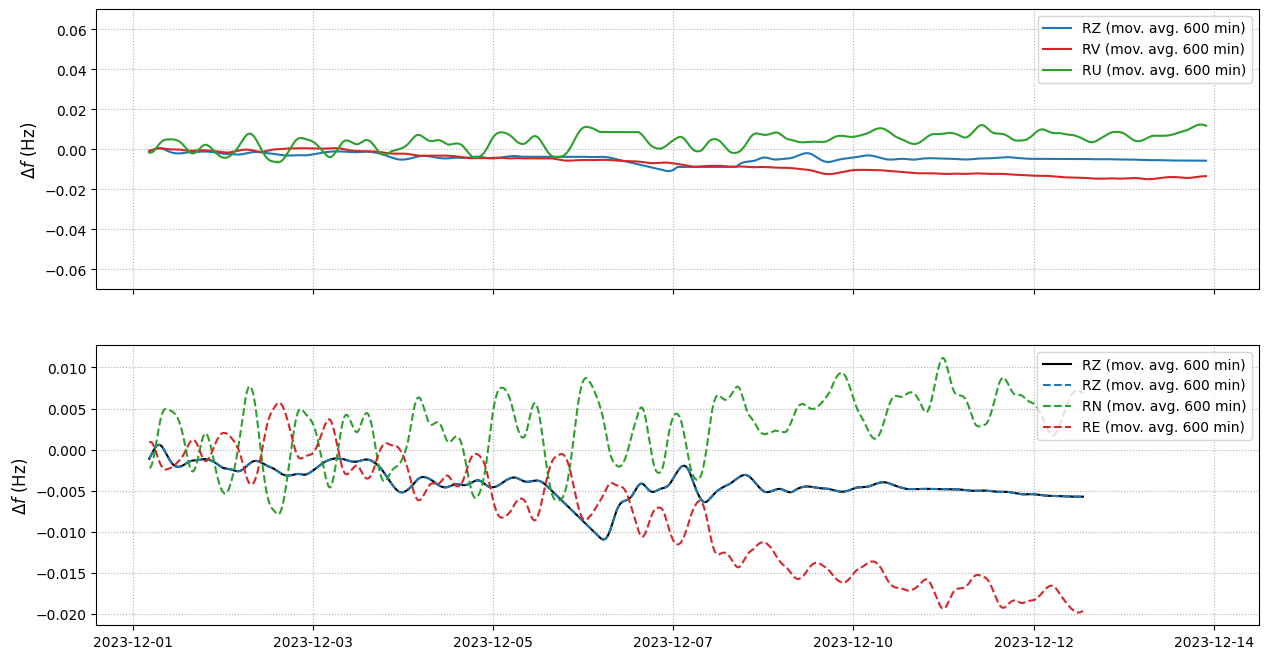

In [44]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    ref_date = UTCDateTime(beatZ.times_utc.iloc[0][:10])

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_reduced, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    ax[0].plot(beatU.times_utc_sec*time_scaling, beatU.fj_reduced, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta f$ (Hz)", fontsize=font)


    # ax[1].plot(beatZ.times_utc_sec*time_scaling, beatZ.tilt_reduced*tilt_scaling, color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)")
    # ax[1].plot(beatV.times_utc_sec*time_scaling, beatV.tilt_reduced*tilt_scaling, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")
    # ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.tilt_reduced*tilt_scaling, color="tab:green", label=f"RU (mov. avg. {n_minutes} min)")

    ax[1].plot(st_beat.select(channel="*Z")[0].times(reftime=ref_date),
               st_beat.select(channel="*Z")[0].data,
               color="black", label=f"RZ (mov. avg. {n_minutes} min)")

    ax[1].plot(st_beat_zne.select(channel="*Z")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*Z")[0].data,
               color="tab:blue", label=f"RZ (mov. avg. {n_minutes} min)", ls="--")
    ax[1].plot(st_beat_zne.select(channel="*N")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*N")[0].data,
               color="tab:green", label=f"RN (mov. avg. {n_minutes} min)", ls="--")
    ax[1].plot(st_beat_zne.select(channel="*E")[0].times(reftime=ref_date),
               st_beat_zne.select(channel="*E")[0].data,
               color="tab:red", label=f"RE (mov. avg. {n_minutes} min)", ls="--")


    # ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)
    ax[1].set_ylabel("$\Delta f$ (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylim(-0.07, 0.07)
    ax[0].set_ylim(-0.07, 0.07)

    ## add dates to x-axis
    ref_date = UTCDateTime(beatZ.times_utc.iloc[0][:10])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();


In [45]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    time_scaling = 1/86400

    ax[0].plot(beatZ.times_mjd, beatZ.fj_inter, color="tab:blue")
    ax[0].plot(beatZ.times_mjd, beatZ.fj_smooth, color="k")
    ax[0].set_ylim(553.48, 553.52)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("Vertikal (Hz)", fontsize=font)

    ax[1].plot(beatU.times_mjd, beatU.fj_inter, color="tab:green")
    ax[1].plot(beatU.times_mjd, beatU.fj_smooth, color="k")
    ax[1].set_ylim(302.4, 302.52)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("Nordring (Hz)", fontsize=font)

    ax[2].plot(beatV.times_mjd, beatV.fj_inter, color="tab:red")
    ax[2].plot(beatV.times_mjd, beatV.fj_smooth, color="k")
    ax[2].set_ylim(447.4, 447.5)
    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("Westring (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[2].set_xlabel("Time (mJD)", fontsize=font)

    plt.show();
    return fig

# fig = __makeplot();


## Tides

In [ ]:
from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from functions.conversion_to_tilt import __conversion_to_tilt

In [ ]:
bromyT =  __read_sds(config['path_to_sds'], "BW.DROMY..LAT", config['tbeg']-600, config['tend']+600)

bromyT = bromyT.detrend("linear").taper(0.01)
bromyT = bromyT.filter("lowpass", freq=0.1, corners=4, zerophase=True)
bromyT = bromyT.resample(0.2)

In [ ]:
bromy =  __read_sds(config['path_to_sds'], "BW.DROMY..LAT", config['tbeg']-600, config['tend']+600)
bromy += __read_sds(config['path_to_sds'], "BW.DROMY..LAN", config['tbeg']-600, config['tend']+600)
bromy += __read_sds(config['path_to_sds'], "BW.DROMY..LAE", config['tbeg']-600, config['tend']+600)

## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

bromy = __conversion_to_tilt(bromy, confTilt['BROMY'])

bromy.trim(config['tbeg'], config['tend'])

bromy.plot(equal_scale=False);


In [ ]:
st_beat_zne_tide = st_beat_zne.copy();

for tr in st_beat_zne_tide:
    tr.data = __interpolate_nan(tr.data)

f1 = 1/(13*3600)
f2 = 1/(11*3600)

st_beat_zne_tide.detrend("linear")
st_beat_zne_tide.taper(0.2)
st_beat_zne_tide.filter("bandpass", freqmin=f1, freqmax=f2, corners=4, zerophase=True)

st_beat_zne_tide.plot(equal_scale=False);


In [ ]:
tr_beatU = Trace()
tr_beatU.data = np.array(beatU.fj_inter)
tr_beatU.stats.delta = 60
tr_beatU.stats.starttime = UTCDateTime(str(beatU.times_utc.iloc[0]))
tr_beatU.plot();

tr_beatV = Trace()
tr_beatV.data = np.array(beatV.fj_inter)
tr_beatV.stats.delta = 60
tr_beatV.stats.starttime = UTCDateTime(str(beatV.times_utc.iloc[0]))
tr_beatV.plot();

tr_beatZ = Trace()
tr_beatZ.data = np.array(beatZ.fj_inter)
tr_beatZ.stats.delta = 60
tr_beatZ.stats.starttime = UTCDateTime(str(beatZ.times_utc.iloc[0]))
tr_beatZ.plot();

f1 = 1/(10*3600)

tr_beatU.detrend("simple")
tr_beatU.taper(0.01)
tr_beatU.filter("lowpass", freq=f1, corners=4, zerophase=True)
tr_beatU.plot();

tr_beatV.detrend("simple")
tr_beatV.taper(0.01)
tr_beatV.filter("lowpass", freq=f1, corners=4, zerophase=True)
tr_beatV.plot();

tr_beatZ.detrend("simple")
tr_beatZ.taper(0.01)
tr_beatZ.filter("lowpass", freq=f1, corners=4, zerophase=True)
tr_beatZ.plot();

In [ ]:
tr_beatU = Trace()
tr_beatU.data = np.array(beatU.fj_inter)
tr_beatU.stats.delta = 60
tr_beatU.stats.starttime = UTCDateTime(str(beatU.times_utc.iloc[0]))
tr_beatU.stats.station = "U"
# tr_beatU.plot();

tr_beatV = Trace()
tr_beatV.data = np.array(beatV.fj_inter)
tr_beatV.stats.delta = 60
tr_beatV.stats.starttime = UTCDateTime(str(beatV.times_utc.iloc[0]))
tr_beatV.stats.station = "V"
# tr_beatV.plot();

tr_beatZ = Trace()
tr_beatZ.data = np.array(beatZ.fj_inter)
tr_beatZ.stats.delta = 60
tr_beatZ.stats.starttime = UTCDateTime(str(beatZ.times_utc.iloc[0]))
tr_beatZ.stats.station = "Z"
# tr_beatZ.plot();

f1 = 1/(13*3600)
f2 = 1/(11*3600)

st_beat = Stream(traces=[tr_beatU, tr_beatV, tr_beatZ])
st_beat.detrend("linear").detrend("simple")
st_beat.taper(0.1)
st_beat.filter("bandpass", freqmin=f1, freqmax=f2, corners=4, zerophase=True)
st_beat.plot(equal_scale=False);

st_beat

In [ ]:
tr_beatU = Trace()
tr_beatU.data = np.array(beatU.fj_inter)
tr_beatU.stats.delta = 60
tr_beatU.stats.starttime = UTCDateTime(str(beatU.times_utc.iloc[0]))
tr_beatU.stats.station = "U"
# tr_beatU.plot();

tr_beatV = Trace()
tr_beatV.data = np.array(beatV.fj_inter)
tr_beatV.stats.delta = 60
tr_beatV.stats.starttime = UTCDateTime(str(beatV.times_utc.iloc[0]))
tr_beatV.stats.station = "V"
# tr_beatV.plot();

tr_beatZ = Trace()
tr_beatZ.data = np.array(beatZ.fj_inter)
tr_beatZ.stats.delta = 60
tr_beatZ.stats.starttime = UTCDateTime(str(beatZ.times_utc.iloc[0]))
tr_beatZ.stats.station = "Z"
# tr_beatZ.plot();


f1 = 1/(25*3600)
f2 = 1/(22*3600)

st_beat = Stream(traces=[tr_beatU, tr_beatV, tr_beatZ])
st_beat.detrend("linear").detrend("simple")
st_beat.taper(0.1)
st_beat.filter("bandpass", freqmin=f1, freqmax=f2, corners=4, zerophase=True)
st_beat.plot(equal_scale=False);

st_beat